In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import scipy
import h5py
import sklearn.datasets 

In [2]:
import import_ipynb
from Utils import ActivationFunctions, LossFunctions, Normalizer

importing Jupyter notebook from Utils.ipynb


## Loading data

In [3]:
trainFilename = "./data/train_catvnoncat.h5"
testFilename = "./data/test_catvnoncat.h5"

In [4]:
def load_dataset():
    train_dataset = h5py.File(trainFilename, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(testFilename, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


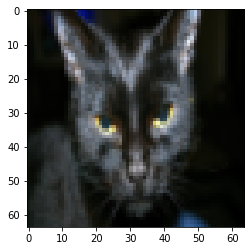

In [6]:
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[:, index]) + ", it's a '" + classes[np.squeeze(train_y[:, index])].decode("utf-8") +  "' picture.")

## Data formalization

In [7]:
# Explore dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## DeepNeuralNetwork Class

In [23]:
class DeepNeuralNetwork():
    activationFunctions = ActivationFunctions()
    normalizer = Normalizer()
    lossFunctions = LossFunctions()
    default_threshold = 0.5
    parameters = {}
    
    def _initialize_parameters_deep(self, layer_dims):
        """
        Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network
        """
        np.random.seed(1)
        parameters = {}
        L = len(layer_dims)            # number of layers in the network
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        return parameters
    
    def _linear_forward(self, A, W, b):
        """
        Implement the linear part of a layer's forward propagation
        """
        Z = W.dot(A) + b
        cache = (A, W, b)
        return Z, cache

    
    def _linear_activation_forward(self, A_prev, W, b, activation):
        """
        Implement the forward propagation for the LINEAR->ACTIVATION layer
        """
        if activation == "sigmoid":
            Z, linear_cache = self._linear_forward(A_prev, W, b)
            A = self.activationFunctions.sigmoid(Z)
        elif activation == "relu":
            Z, linear_cache = self._linear_forward(A_prev, W, b)
            A = self.activationFunctions.reLU(Z)

        cache = (linear_cache, Z)

        return A, cache
    
    def _L_model_forward(self, X, parameters):
        """
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
        """
        caches = []
        A = X
        L = len(parameters) // 2                  # number of layers in the neural network

        # Implement [LINEAR -> RELU]*(L-1).
        for l in range(1, L):
            A_prev = A 
            A, cache = self._linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
            caches.append(cache)

        # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
        AL, cache = self._linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
        caches.append(cache)
        return AL, caches
    
    def _compute_cost(self, AL, Y):
        """
        Implement the cost function defined by equation (7).
        """

        m = Y.shape[1]

        # Compute loss from aL and y.
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))

        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect

        return cost
    
    def _linear_backward(self, dZ, cache):
        """
        Implement the linear portion of backward propagation for a single layer (layer l)
        """
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)
        return dA_prev, dW, db
    
    def _linear_activation_backward(self, dA, cache, activation):
        """
        Implement the backward propagation for the LINEAR->ACTIVATION layer.
        """
        linear_cache, activation_cache = cache

        if activation == "relu":
            dZ = self.activationFunctions.reLU_backward(dA, activation_cache)
            dA_prev, dW, db = self._linear_backward(dZ, linear_cache)

        elif activation == "sigmoid":
            dZ = self.activationFunctions.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self._linear_backward(dZ, linear_cache)

        return dA_prev, dW, db
    
    def _L_model_backward(self, AL, Y, caches):
        """
        Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
        """
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

        # Initializing the backpropagation
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        # Lth layer (SIGMOID -> LINEAR) gradients
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self._linear_activation_backward(dAL, current_cache, activation = "sigmoid")

        for l in reversed(range(L-1)):
            # lth layer: (RELU -> LINEAR) gradients.
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self._linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
    
    
    def _update_parameters(self, parameters, grads, learning_rate):
        """
        Update parameters using gradient descent

        Arguments:
        parameters -- python dictionary containing your parameters 
        grads -- python dictionary containing your gradients, output of L_model_backward

        Returns:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
        """

        L = len(parameters) // 2 # number of layers in the neural network

        # Update rule for each parameter. Use a for loop.
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

        return parameters
    
    def train(self, X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
        """
        Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
        """

        np.random.seed(1)
        costs = []                         # keep track of cost

        # Parameters initialization. (≈ 1 line of code)
        parameters = self._initialize_parameters_deep(layers_dims)

        # Loop (gradient descent)
        for i in range(0, num_iterations):

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = self._L_model_forward(X, parameters)

            # Compute cost.
            cost = self._compute_cost(AL, Y)

            # Backward propagation.
            grads = self._L_model_backward(AL, Y, caches)

            # Update parameters.
            parameters = self._update_parameters(parameters, grads, learning_rate)

            # Print the cost every 100 training example
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        self.parameters = parameters
        
        return parameters
    
    def predict(self, X, threshold = default_threshold):
        '''
        Predict on X dataset
        '''
        AL, cache =  self._L_model_forward(X, parameters)
        predictions = np.where(AL > threshold, 1, 0)

        return predictions  
    
    def get_metrics(self, X, Y, threshold = default_threshold, show_results = False):
        
        Y_predict = self.predict(X, threshold)

        # Print train/test Errors
        if show_results: print("Accuracy: {} %".format(100 - np.mean(np.abs(Y_predict - Y)) * 100))
        return {"Accuracy": (1 - np.mean(np.abs(Y_predict - Y)))}



## Creating & training model

In [24]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

deepNeuralNetwork = DeepNeuralNetwork()


Cost after iteration 0: 0.771749
Cost after iteration 100: 0.668643
Cost after iteration 200: 0.644902
Cost after iteration 300: 0.585219
Cost after iteration 400: 0.521544
Cost after iteration 500: 0.490371
Cost after iteration 600: 0.388918
Cost after iteration 700: 0.366900
Cost after iteration 800: 0.398332
Cost after iteration 900: 0.351117
Cost after iteration 1000: 0.250425
Cost after iteration 1100: 0.167711
Cost after iteration 1200: 0.143310
Cost after iteration 1300: 0.125508
Cost after iteration 1400: 0.111445
Cost after iteration 1500: 0.100332
Cost after iteration 1600: 0.091003
Cost after iteration 1700: 0.082590
Cost after iteration 1800: 0.075972
Cost after iteration 1900: 0.071135
Cost after iteration 2000: 0.065827
Cost after iteration 2100: 0.063602
Cost after iteration 2200: 0.057674
Cost after iteration 2300: 0.054198
Cost after iteration 2400: 0.051434


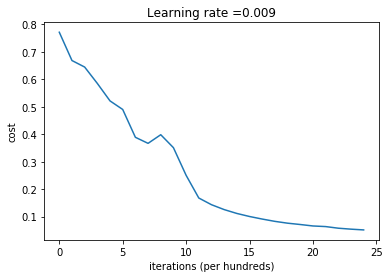

In [25]:
parameters = deepNeuralNetwork.train(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True, learning_rate=0.009)

In [26]:
print("Train set metrics:", deepNeuralNetwork.get_metrics(train_x, train_y))
print("Test set metrics:", deepNeuralNetwork.get_metrics(test_x, test_y))

Train set metrics: {'Accuracy': 0.9952153110047847}
Test set metrics: {'Accuracy': 0.8}


## Check labelled images

In [27]:
def print_labeled_correctly_images(classes, X, y, p, image_class = "cat"):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == (2 if image_class == "cat" else 0)))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [28]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [33]:
pred_train = deepNeuralNetwork.predict(train_x)
pred_test = deepNeuralNetwork.predict(test_x)

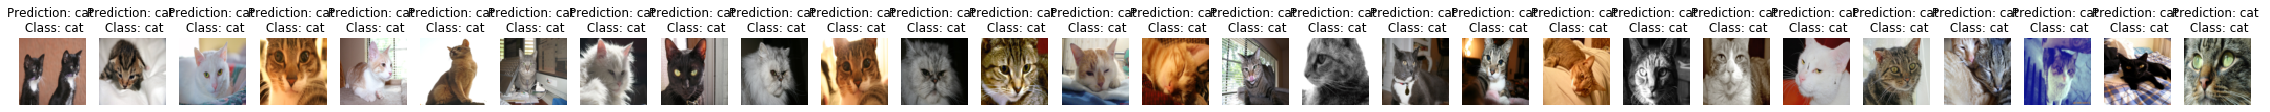

In [34]:
#Well classified cats
print_labeled_correctly_images(classes, test_x, test_y, pred_test, image_class="cat")

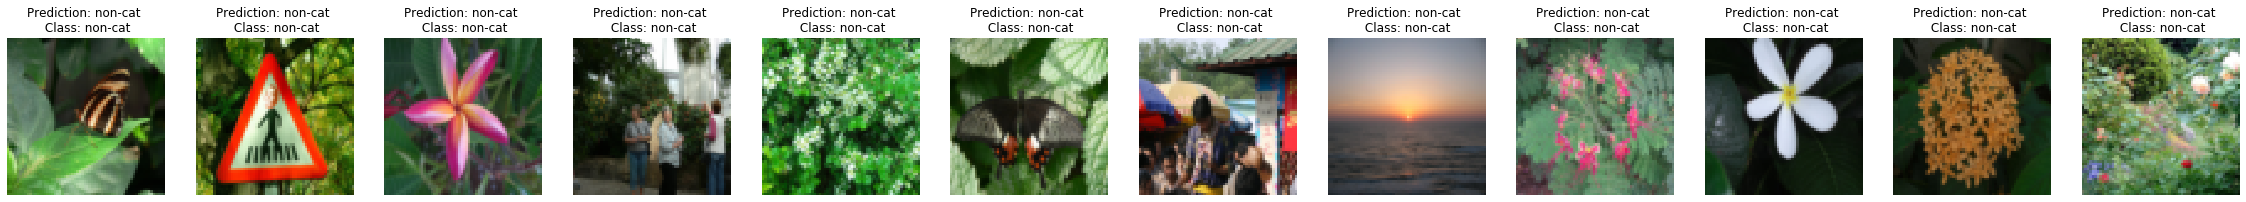

In [35]:
#Well classified non cats
print_labeled_correctly_images(classes, test_x, test_y, pred_test, image_class="non-cat")

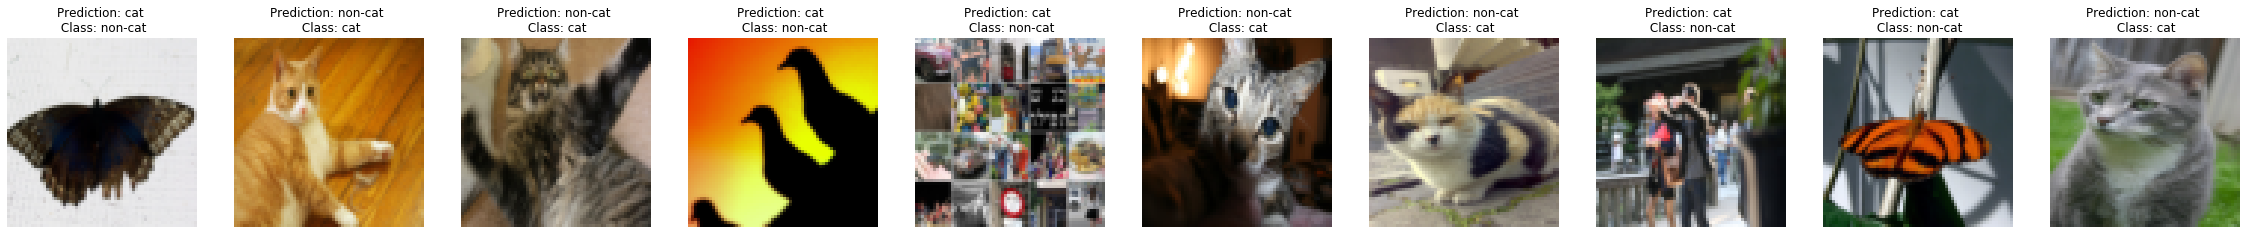

In [36]:
#Wrongly classified non cats & cats
print_mislabeled_images(classes, test_x, test_y, pred_test)